### Simple 1D example of `DDPM`

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch as th
import torch.nn as nn
import torch.nn.functional as F
from util import (
    gp_sampler,
    get_torch_size_string,
    plot_1xN_torch_traj_tensor,
)
from diffusion import (
    get_ddpm_constants,
    plot_ddpm_constants,
    DiffusionUNet,
    forward_sample,
)
from dataset import mnist
np.set_printoptions(precision=3)
th.set_printoptions(precision=3)
plt.rc('xtick',labelsize=8)
plt.rc('ytick',labelsize=8)
%matplotlib inline
%config InlineBackend.figure_format='retina'
print ("PyTorch version:[%s]."%(th.__version__))

PyTorch version:[2.0.1].


### Initialize

[ 0] key:[schedule_name]
[ 1] key:[T]
[ 2] key:[timesteps]
[ 3] key:[betas]
[ 4] key:[alphas]
[ 5] key:[alphas_bar]
[ 6] key:[alphas_bar_prev]
[ 7] key:[sqrt_recip_alphas]
[ 8] key:[sqrt_alphas_bar]
[ 9] key:[sqrt_one_minus_alphas_bar]
[10] key:[posterior_variance]


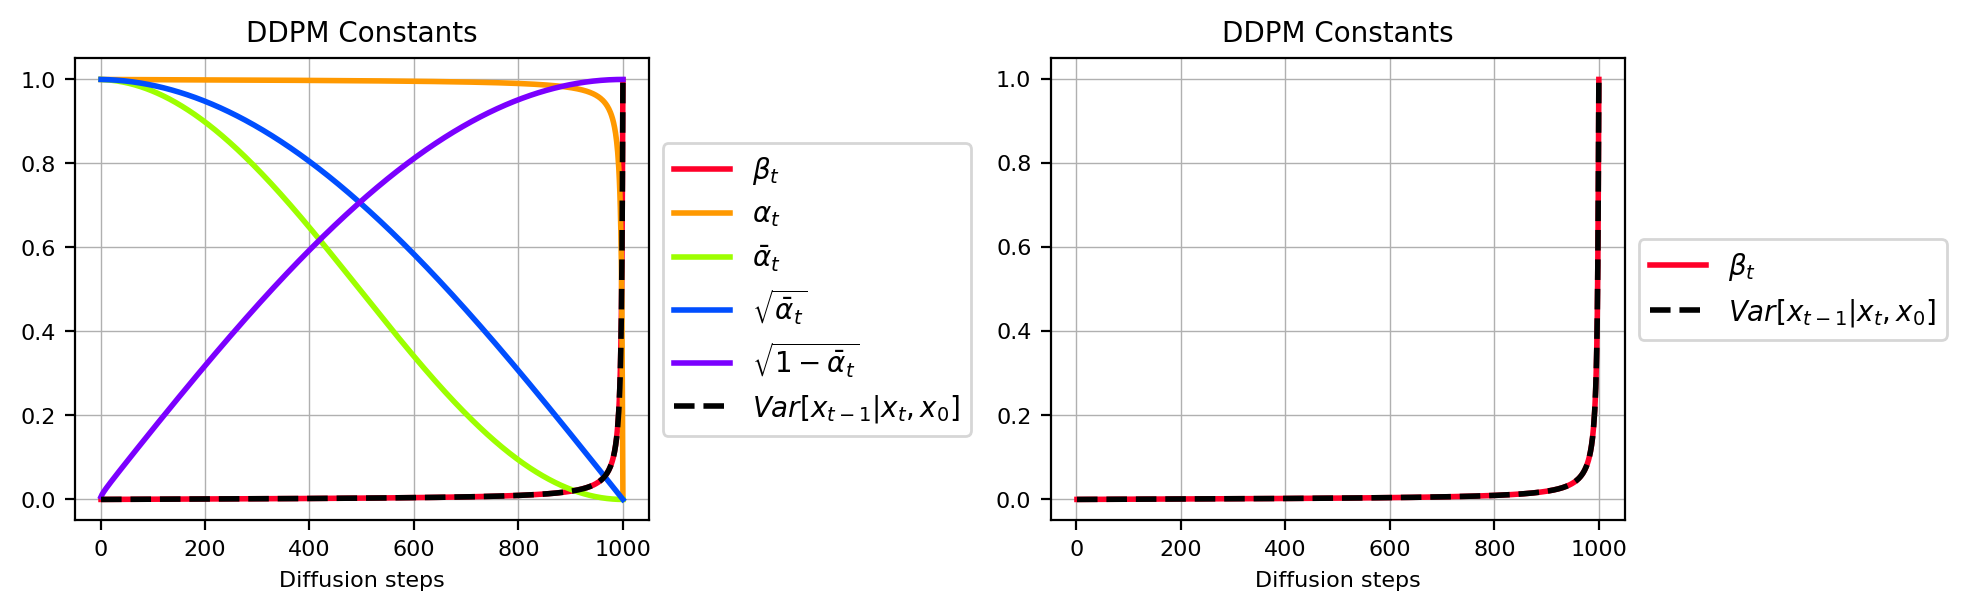

In [2]:
dc = get_ddpm_constants(
    schedule_name = 'cosine', # 'linear', 'cosine'
    T             = 1000,
    np_type       = np.float32,
)
for k_idx,key in enumerate(dc.keys()):
    print ("[%2d] key:[%s]"%(k_idx,key))
plot_ddpm_constants(dc)

In [3]:
# Instantiate U-net
device = 'mps'
model = DiffusionUNet(
    name             = 'unet',
    dims             = 1,
    n_in_channels    = 1,
    n_model_channels = 64,
    n_emb_dim        = 128,
    n_enc_blocks     = 2, # number of encoder blocks
    n_dec_blocks     = 2, # number of decoder blocks
    n_groups         = 16, # group norm paramter
    device           = device,
) # input:[B x C x L] => output:[B x C x L]
print ("Ready.")

Ready.


### Training data `x_0`: [N x C x L]
where N is the number of data, C is the channel size, and L is the length of trajectories

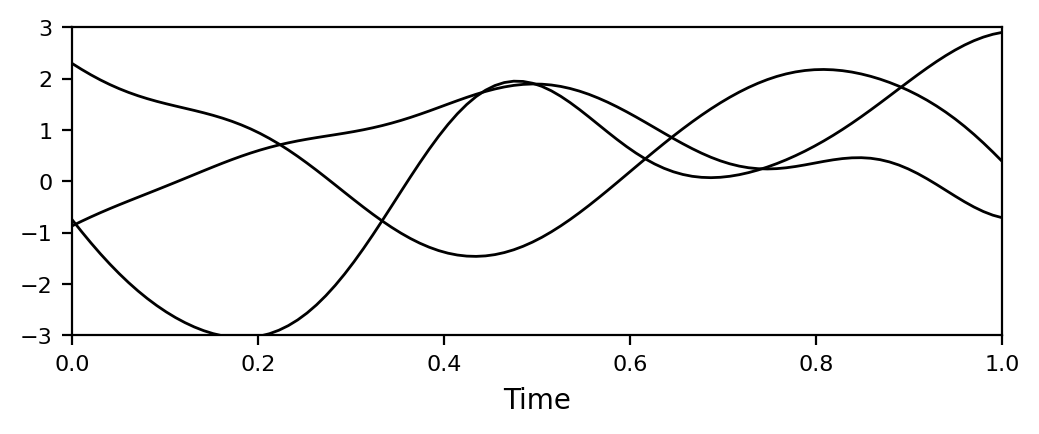

x_0:[3x1x100]


In [4]:
np.random.seed(seed=1)
n_traj = 3
times = np.linspace(start=0.0,stop=1.0,num=100).reshape((-1,1)) # [L x 1]
traj = th.from_numpy(
    gp_sampler(
        times    = times,
        hyp_gain = 2.0,
        hyp_len  = 0.2,
        meas_std = 1e-8,
        n_traj   = n_traj
    )
).to(th.float32).to(device) # [L x 10]
# Plot
plt.figure(figsize=(6,2))
for t_idx in range(n_traj):
    plt.plot(times,traj[t_idx,:].cpu().numpy(),ls='-',color='k',lw=1)
plt.xlim([0.0,1.0]); plt.ylim([-3,+3]);
plt.xlabel('Time',fontsize=10)
plt.show()
# Print
x_0 = traj[:,None,:] # [N x C x L]
print ("x_0:[%s]"%(get_torch_size_string(x_0)))

### Train

In [5]:
def eval_ddpm_1d(model,dc,n_sample,x_0,device):
    _,C,L = x_0.shape
    x_dummy = th.zeros(n_sample,C,L,device=device)
    step_dummy = th.zeros(n_sample).type(th.long).to(device)
    _,x_T = forward_sample(x_dummy,step_dummy,dc) # [N x C x L]
    x_t = x_T.clone() # [N x C x L]
    x_t_list = ['']*dc['T']
    for t in range(0,dc['T'])[::-1]: # 999 to 0
        # Score function
        step = th.full(size=(n_sample,),fill_value=t,device=device,dtype=th.long) # [N]
        eps_t,_ = model(x_t,step) # [N x C x L]
        betas_t = th.gather(
            input = th.from_numpy(dc['betas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [N x 1 x 1]
        sqrt_one_minus_alphas_bar_t = th.gather(
            input = th.from_numpy(dc['sqrt_one_minus_alphas_bar']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [N x 1 x 1]
        sqrt_recip_alphas_t = th.gather(
            input = th.from_numpy(dc['sqrt_recip_alphas']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [N x 1 x 1]
        # Compute posterior mean
        mean_t = sqrt_recip_alphas_t * (
            x_t - betas_t*eps_t/sqrt_one_minus_alphas_bar_t
            ) # [N x C x L]
        # Compute posterior variance
        posterior_variance_t = th.gather(
            input = th.from_numpy(dc['posterior_variance']).to(device), # [T]
            dim   = -1,
            index = step
        ).reshape((-1,1,1)) # [N x 1 x 1]
        # Sample
        if t == 0: # last sampling, use mean
            x_t = mean_t
        else:
            _,noise_t = forward_sample(x_dummy,step_dummy,dc) # [N x C x 1]
            x_t = mean_t + th.sqrt(posterior_variance_t)*noise_t
        # Append
        x_t_list[t] = x_t
    # Plot
    for t in np.linspace(dc['T']-1,0,5).astype(np.int32):
        x_t = x_t_list[t] # [N x C x L]
        x_t_np = x_t.detach().cpu().numpy() # [N x C x L]
        plt.figure(figsize=(6,2))
        for i_idx in range(n_sample):
            plt.plot(times.flatten(),x_t_np[i_idx,0,:],ls='-',color='k',lw=1)
        plt.xlim([0.0,1.0])
        # plt.ylim([-3,+3])
        plt.xlabel('Time',fontsize=8)
        plt.title('Step:[%d]'%(t),fontsize=8)
        plt.show()
print ("Ready.")

Ready.


In [ ]:
max_iter    = int(1e4)
batch_size  = 128
print_every = 1e3
eval_every  = 1e3

# Loop
model.train()
optm = th.optim.AdamW(params=model.parameters(),lr=1e-4,weight_decay=1e-4)
schd = th.optim.lr_scheduler.ExponentialLR(optimizer=optm,gamma=0.998)
for it in range(max_iter):
    
    # Zero gradient
    optm.zero_grad()
    
    # Get batch
    idx = np.random.choice(x_0.shape[0],batch_size)
    x_0_batch = x_0[idx,:,:] # [B x C x L]
    
    # Sample time steps
    step_batch = th.randint(0, dc['T'],(batch_size,),device=device).long() # [B]
    
    # Forward diffusion sampling
    x_t_batch,noise = forward_sample(x_0_batch,step_batch,dc)

    # Model predict
    noise_pred,_ = model(x_t_batch,step_batch)
    
    # Compute error
    loss = F.mse_loss(noise,noise_pred)
    
    # Update
    loss.backward()
    optm.step()
    schd.step()
    
    # Print
    if (it%print_every) == 0 or it == (max_iter-1):
        print ("it:[%7d] loss:[%.4f]"%(it,loss.item()))
    
    # Evaluate
    if (it%eval_every) == 0 or it == (max_iter-1):
        n_sample = 10
        eval_ddpm_1d(model,dc,n_sample,x_0,device)
    
print ("Done.")    

it:[    0] loss:[1.2767]
